In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Groundwater Level (WTE) Data Quality Check

In [2]:
import os
import pandas as pd

file_path = '../data/raw/groundwater/GSLB_1900-2023_TS_with_aquifers.csv'

if os.path.exists(file_path):
    wte_data = pd.read_csv(file_path)
    wte_data['Date'] = pd.to_datetime(wte_data['Date'])
    print("File loaded successfully!")
else:
    print(f"File not found: {file_path}. Please make sure the file exists at the specified path.")

File loaded successfully!


Wells with single measurement: 4837 (56.2%)
Wells with two measurements: 827 (9.6%)

Detailed Quality Report:
--------------------------------------------------
Total number of wells: 8602
Wells with single measurement: 4837
Wells with two measurements: 827
Average measurements per well: 20.60
Median measurements per well: 1.00
Average time span per well: 3133.24 days
Average measurements per year: 1.97


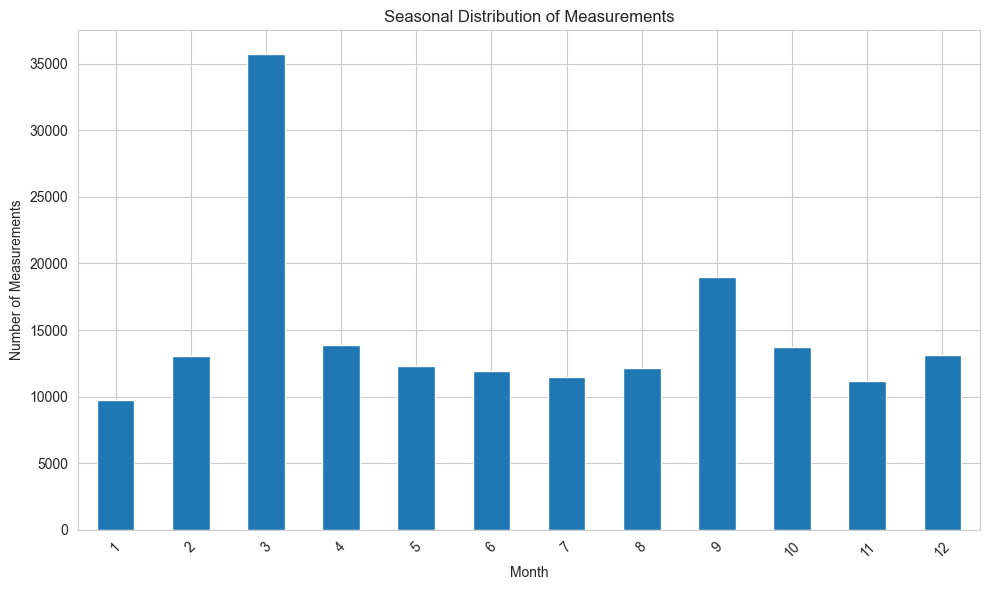

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_wte_data_quality(df):
    """
    Analyze the quality of water table elevation (WTE) data
    Parameters:
        df: DataFrame containing WTE measurements with columns 'Well_ID', 'Date', 'WTE'
    Returns:
        report: Dictionary containing quality metrics
    """
    # 1. Analysis of measurement counts per well
    measurement_counts = df.groupby('Well_ID').size()

    # Count wells with limited measurements
    single_point_wells = measurement_counts[measurement_counts == 1]
    two_point_wells = measurement_counts[measurement_counts == 2]

    print(f"Wells with single measurement: {len(single_point_wells)} ({len(single_point_wells)/len(measurement_counts):.1%})")
    print(f"Wells with two measurements: {len(two_point_wells)} ({len(two_point_wells)/len(measurement_counts):.1%})")

    # 2. Time span analysis
    time_analysis = df.groupby('Well_ID').agg({
        'Date': lambda x: (x.max() - x.min()).days if len(x) > 1 else 0
    }).rename(columns={'Date': 'time_span_days'})

    # 3. Measurement frequency analysis
    df['Year'] = df['Date'].dt.year
    measurements_per_year = df.groupby(['Well_ID', 'Year']).size().reset_index(name='measurements')
    avg_measurements_per_year = measurements_per_year.groupby('Well_ID')['measurements'].mean()

    # 4. Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 4.1 Distribution of measurements per well
    measurement_counts.hist(bins=50, ax=ax1)
    ax1.set_title('Distribution of Measurements per Well')
    ax1.set_xlabel('Number of Measurements')
    ax1.set_ylabel('Number of Wells')

    # 4.2 Distribution of time spans
    time_analysis['time_span_days'].hist(bins=50, ax=ax2)
    ax2.set_title('Distribution of Time Span per Well')
    ax2.set_xlabel('Time Span (days)')
    ax2.set_ylabel('Number of Wells')

    # 4.3 WTE distribution
    sns.boxplot(y='WTE', data=df, ax=ax3)
    ax3.set_title('WTE Distribution')

    # 4.4 Average measurements per year
    avg_measurements_per_year.hist(bins=30, ax=ax4)
    ax4.set_title('Average Measurements per Year')
    ax4.set_xlabel('Average Measurements')
    ax4.set_ylabel('Number of Wells')

    plt.tight_layout()

    # 5. Generate quality report
    report = {
        'total_wells': len(measurement_counts),
        'single_point_wells': len(single_point_wells),
        'two_point_wells': len(two_point_wells),
        'avg_measurements_per_well': measurement_counts.mean(),
        'median_measurements_per_well': measurement_counts.median(),
        'avg_time_span_days': time_analysis['time_span_days'].mean(),
        'avg_measurements_per_year': avg_measurements_per_year.mean()
    }

    # Print detailed report
    print("\nDetailed Quality Report:")
    print("-" * 50)
    print(f"Total number of wells: {report['total_wells']}")
    print(f"Wells with single measurement: {report['single_point_wells']}")
    print(f"Wells with two measurements: {report['two_point_wells']}")
    print(f"Average measurements per well: {report['avg_measurements_per_well']:.2f}")
    print(f"Median measurements per well: {report['median_measurements_per_well']:.2f}")
    print(f"Average time span per well: {report['avg_time_span_days']:.2f} days")
    print(f"Average measurements per year: {report['avg_measurements_per_year']:.2f}")

    return report

def analyze_seasonal_distribution(df):
    """
    Analyze the seasonal distribution of measurements
    Parameters:
        df: DataFrame containing measurements with 'Date' column
    Returns:
        seasonal_dist: Series containing count of measurements per month
    """
    df['Month'] = df['Date'].dt.month
    seasonal_dist = df.groupby('Month').size()

    plt.figure(figsize=(10, 6))
    seasonal_dist.plot(kind='bar')
    plt.title('Seasonal Distribution of Measurements')
    plt.xlabel('Month')
    plt.ylabel('Number of Measurements')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return seasonal_dist

# Run the analysis
report = analyze_wte_data_quality(wte_data)
seasonal_distribution = analyze_seasonal_distribution(wte_data)

# Hydrography data

In [4]:
# Hydrography Data Analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load hydrography data
hydrography_path = '../data/raw/hydrography/'

try:
    # Load shapefiles with error handling
    gsl_basin = gpd.read_file(hydrography_path + 'gsl_basin.shp')
    gsl_catchment = gpd.read_file(hydrography_path + 'gsl_catchment.shp')
    gslb_stream = gpd.read_file(hydrography_path + 'gslb_stream.shp')
    lake = gpd.read_file(hydrography_path + 'lake.shp')
    well_shp = gpd.read_file(hydrography_path + 'well_shp.shp')
    
    # Load CSV data
    gsl_nwm_gage = pd.read_csv(hydrography_path + 'gsl_nwm_gage.csv')
    
    print("Hydrography data loaded successfully!")
    print(f"Basin features: {len(gsl_basin)}")
    print(f"Catchment features: {len(gsl_catchment)}")
    print(f"Stream features: {len(gslb_stream)}")
    print(f"Lake features: {len(lake)}")
    print(f"Well features: {len(well_shp)}")
    print(f"Gage data points: {len(gsl_nwm_gage)}")
    
    # Check coordinate reference systems
    print(f"\nCoordinate Reference Systems:")
    print(f"Basin CRS: {gsl_basin.crs}")
    print(f"Catchment CRS: {gsl_catchment.crs}")
    print(f"Stream CRS: {gslb_stream.crs}")
    print(f"Lake CRS: {lake.crs}")
    print(f"Well CRS: {well_shp.crs}")
    
except Exception as e:
    print(f"Error loading hydrography data: {e}")
    print("Please check file paths and data integrity.")

Hydrography data loaded successfully!
Basin features: 1
Catchment features: 7013
Stream features: 6717
Lake features: 202
Well features: 8752
Gage data points: 78

Coordinate Reference Systems:
Basin CRS: EPSG:4269
Catchment CRS: EPSG:4326
Stream CRS: EPSG:4326
Lake CRS: EPSG:4269
Well CRS: EPSG:4326


In [ ]:
# Create comprehensive hydrography plots with improved error handling
try:
    # Ensure all data has the same CRS for proper plotting
    target_crs = gsl_basin.crs
    
    # Reproject if necessary
    if gsl_catchment.crs != target_crs:
        gsl_catchment = gsl_catchment.to_crs(target_crs)
    if gslb_stream.crs != target_crs:
        gslb_stream = gslb_stream.to_crs(target_crs)
    if lake.crs != target_crs:
        lake = lake.to_crs(target_crs)
    if well_shp.crs != target_crs:
        well_shp = well_shp.to_crs(target_crs)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Basin and catchment overview
    ax1 = axes[0, 0]
    gsl_basin.plot(ax=ax1, color='#E3F2FD', alpha=0.7, edgecolor='#1976D2', linewidth=1.5)
    gsl_catchment.plot(ax=ax1, color='#E8F5E9', alpha=0.5, edgecolor='#43A047', linewidth=0.3)
    ax1.set_title('GSL Basin and Catchments')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.text(0.02, 0.98, f'Basin: 1\nCatchments: {len(gsl_catchment)}',
             transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Streams
    ax2 = axes[0, 1]
    gsl_basin.plot(ax=ax2, color='none', edgecolor='#1976D2', linewidth=0.8, alpha=0.5)
    gslb_stream.plot(ax=ax2, color='#2196F3', linewidth=0.8)
    ax2.set_title('Stream Network')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.text(0.02, 0.98, f'Streams: {len(gslb_stream)}',
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Lakes
    ax3 = axes[1, 0]
    gsl_basin.plot(ax=ax3, color='none', edgecolor='#1976D2', linewidth=0.8, alpha=0.5)
    if len(lake) > 0:
        lake.plot(ax=ax3, color='#0D47A1', alpha=0.6)
    ax3.set_title('Lakes')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    ax3.text(0.02, 0.98, f'Lakes: {len(lake)}',
             transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Well locations with water features
    ax4 = axes[1, 1]
    gsl_basin.plot(ax=ax4, color='#E3F2FD', alpha=0.3, edgecolor='#1976D2', linewidth=1)
    gslb_stream.plot(ax=ax4, color='#2196F3', linewidth=0.5, alpha=0.6, label='Streams')
    if len(lake) > 0:
        lake.plot(ax=ax4, color='#0D47A1', alpha=0.6, label='Lakes')
    well_shp.plot(ax=ax4, color='#E53935', markersize=0.5, alpha=0.6, label='Wells')
    ax4.set_title('Wells and Water Features Overview')
    ax4.set_xlabel('Longitude')
    ax4.set_ylabel('Latitude')
    ax4.text(0.02, 0.98, f'Wells: {len(well_shp)}',
             transform=ax4.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    ax4.legend(loc='lower right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating plots: {e}")
    print("Check that all data loaded correctly and has valid geometries.")

# streamflow

Gage Data Summary:
         id                                               name  \
0  10011200  WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...   
1  10011500            BEAR RIVER NEAR UTAH-WYOMING STATE LINE   
2  10015700  SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...   
3  10015900       SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.   
4  10016900                        BEAR RIVER AT EVANSTON - WY   

                  River   latitude   longitude  elevation_m    state  
0  WEST FORK BEAR RIVER  40.841614 -110.927119         2797     Utah  
1            BEAR RIVER  40.965225 -110.853508         2432     Utah  
2         SULPHUR CREEK  41.129114 -110.806563         2205  Wyoming  
3         SULPHUR CREEK  41.156058 -110.835176         2173  Wyoming  
4            BEAR RIVER  41.270224 -110.963793         2057  Wyoming  

Number of gages: 78
States represented: ['Utah' 'Wyoming' 'Idaho']
Elevation range: 1286 - 2797 m


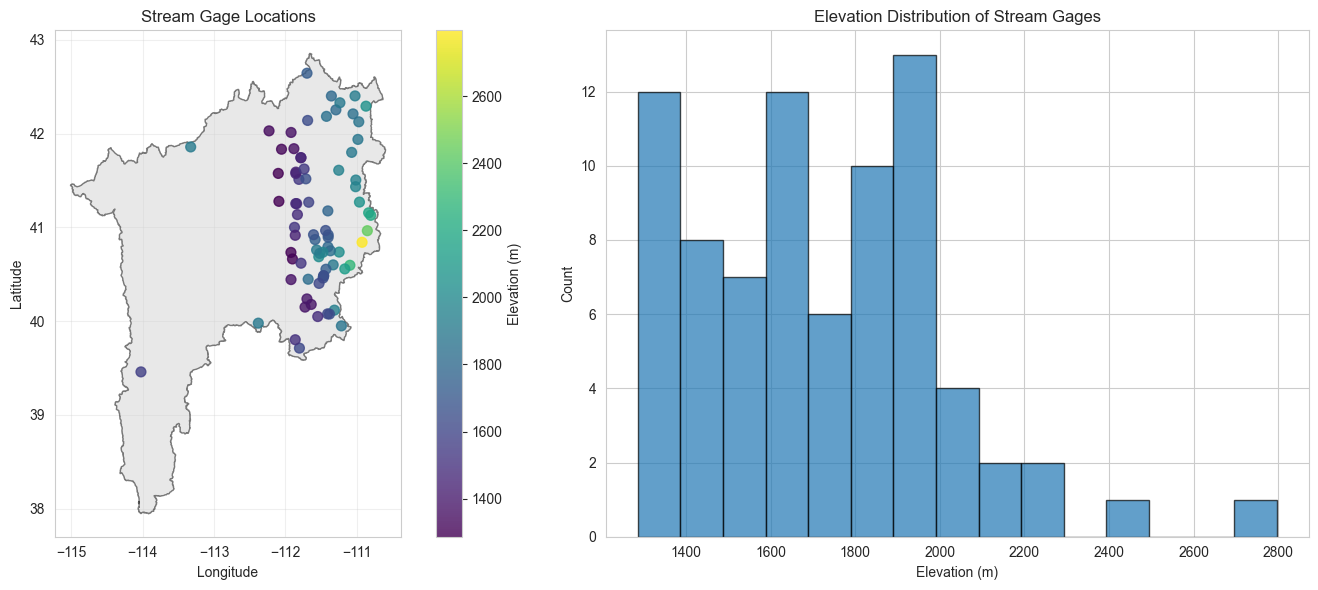

In [6]:
# Analyze gage data with improved error handling
try:
    print("Gage Data Summary:")
    print(gsl_nwm_gage.head())
    print(f"\nNumber of gages: {len(gsl_nwm_gage)}")
    print(f"States represented: {gsl_nwm_gage['state'].unique()}")
    
    # Check for missing elevation data
    if 'elevation_m' in gsl_nwm_gage.columns:
        elev_data = gsl_nwm_gage['elevation_m'].dropna()
        if len(elev_data) > 0:
            print(f"Elevation range: {elev_data.min():.0f} - {elev_data.max():.0f} m")
        else:
            print("No elevation data available")
    else:
        print("Elevation column not found")
    
    # Plot gage locations with elevation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gage locations
    gsl_basin.plot(ax=ax1, color='lightgray', alpha=0.5, edgecolor='black')
    
    if 'elevation_m' in gsl_nwm_gage.columns and len(elev_data) > 0:
        # Filter out rows with missing coordinates or elevation
        gage_clean = gsl_nwm_gage.dropna(subset=['longitude', 'latitude', 'elevation_m'])
        
        scatter = ax1.scatter(gage_clean['longitude'], gage_clean['latitude'], 
                             c=gage_clean['elevation_m'], cmap='viridis', s=50, alpha=0.8)
        plt.colorbar(scatter, ax=ax1, label='Elevation (m)')
        
        # Elevation distribution
        ax2.hist(gage_clean['elevation_m'], bins=15, alpha=0.7, edgecolor='black')
        ax2.set_title('Elevation Distribution of Stream Gages')
        ax2.set_xlabel('Elevation (m)')
        ax2.set_ylabel('Count')
    else:
        # Plot without elevation coloring
        gage_clean = gsl_nwm_gage.dropna(subset=['longitude', 'latitude'])
        ax1.scatter(gage_clean['longitude'], gage_clean['latitude'], 
                   color='red', s=50, alpha=0.8)
        ax2.text(0.5, 0.5, 'No elevation data\navailable for histogram', 
                ha='center', va='center', transform=ax2.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax1.set_title('Stream Gage Locations')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error analyzing gage data: {e}")
    print("Check data format and column names.")

## gage classification

In [12]:
# Load GAGES-II reference and non-reference classification data
gage_with_class = pd.read_excel('../data/raw/streamflow/GAGES-II_ref_non_ref.xlsx')

In [15]:
gage_with_class.head()

STAID    CLASS
0  1011000  Non-ref
1  1013500      Ref
2  1015800  Non-ref
3  1016500  Non-ref
4  1017000  Non-ref

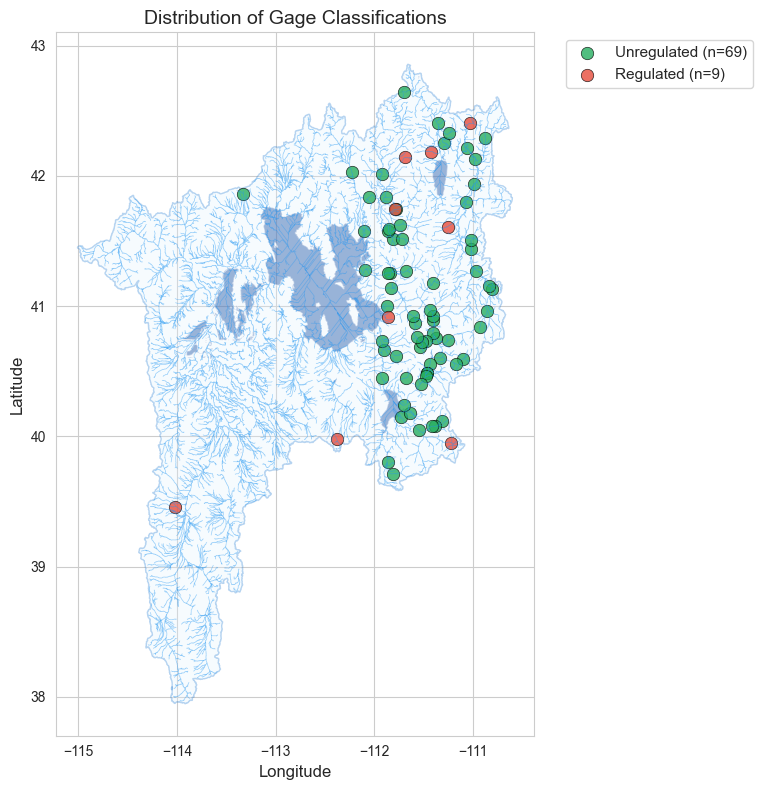

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot basin boundary
gsl_basin.plot(ax=ax1, color='#E3F2FD', alpha=0.3, edgecolor='#1976D2', linewidth=1)

# Plot streams and lakes
gslb_stream.plot(ax=ax1, color='#2196F3', linewidth=0.5, alpha=0.4)
lake.plot(ax=ax1, color='#0D47A1', alpha=0.4)

# Merge gage_with_class with gage_clean to get coordinates
gage_with_coords = gage_clean.merge(gage_with_class, left_on='id', right_on='STAID', how='inner')

# Create a mapping for renaming classes
class_rename = {
    'Ref': 'Regulated',
    'Non-ref': 'Unregulated'
}

# Rename classes in the dataframe
gage_with_coords['CLASS_DISPLAY'] = gage_with_coords['CLASS'].fillna('Unclassified').map(
    lambda x: class_rename.get(x, x)
)

# Define distinct colors for each class
color_dict = {
    'Regulated': '#E74C3C',      # Bright red
    'Unregulated': '#27AE60',    # Bright green
    'Unclassified': '#95A5A6'    # Gray
}

# Get unique classes
unique_classes = gage_with_coords['CLASS_DISPLAY'].unique()

# Plot each class and count stations
for class_type in unique_classes:
    mask = gage_with_coords['CLASS_DISPLAY'] == class_type
    subset = gage_with_coords[mask]
    count = len(subset)
    ax1.scatter(subset['longitude'], subset['latitude'],
               c=color_dict.get(class_type, '#95A5A6'),
               label=f'{class_type} (n={count})',
               s=80,           # Larger points
               alpha=0.8,      # More opaque
               edgecolors='black',  # Black outline for better visibility
               linewidths=0.5)

ax1.set_title('Distribution of Gage Classifications', fontsize=14)
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

## reach elevation

In [22]:
reach_elev = pd.read_csv('../data/raw/streamflow/reach_centroids_with_Elev.csv')

In [23]:
print("Reach elevation data summary:")
print(f"Total reaches: {len(reach_elev)}")
print("\nSummary statistics:")
print(reach_elev[['NASA_GSE', 'AW3D_GSE', 'Avg_GSE']].describe())

Reach elevation data summary:
Total reaches: 6717

Summary statistics:
          NASA_GSE     AW3D_GSE      Avg_GSE
count  6717.000000  6717.000000  6717.000000
mean   1560.739765  1561.838618  1561.289192
std     292.451344   292.616663   292.526091
min    1257.000000  1252.000000  1266.000000
25%    1305.000000  1305.000000  1305.000000
50%    1477.000000  1478.000000  1477.500000
75%    1750.000000  1752.000000  1751.000000
max    3112.000000  3123.000000  3117.500000


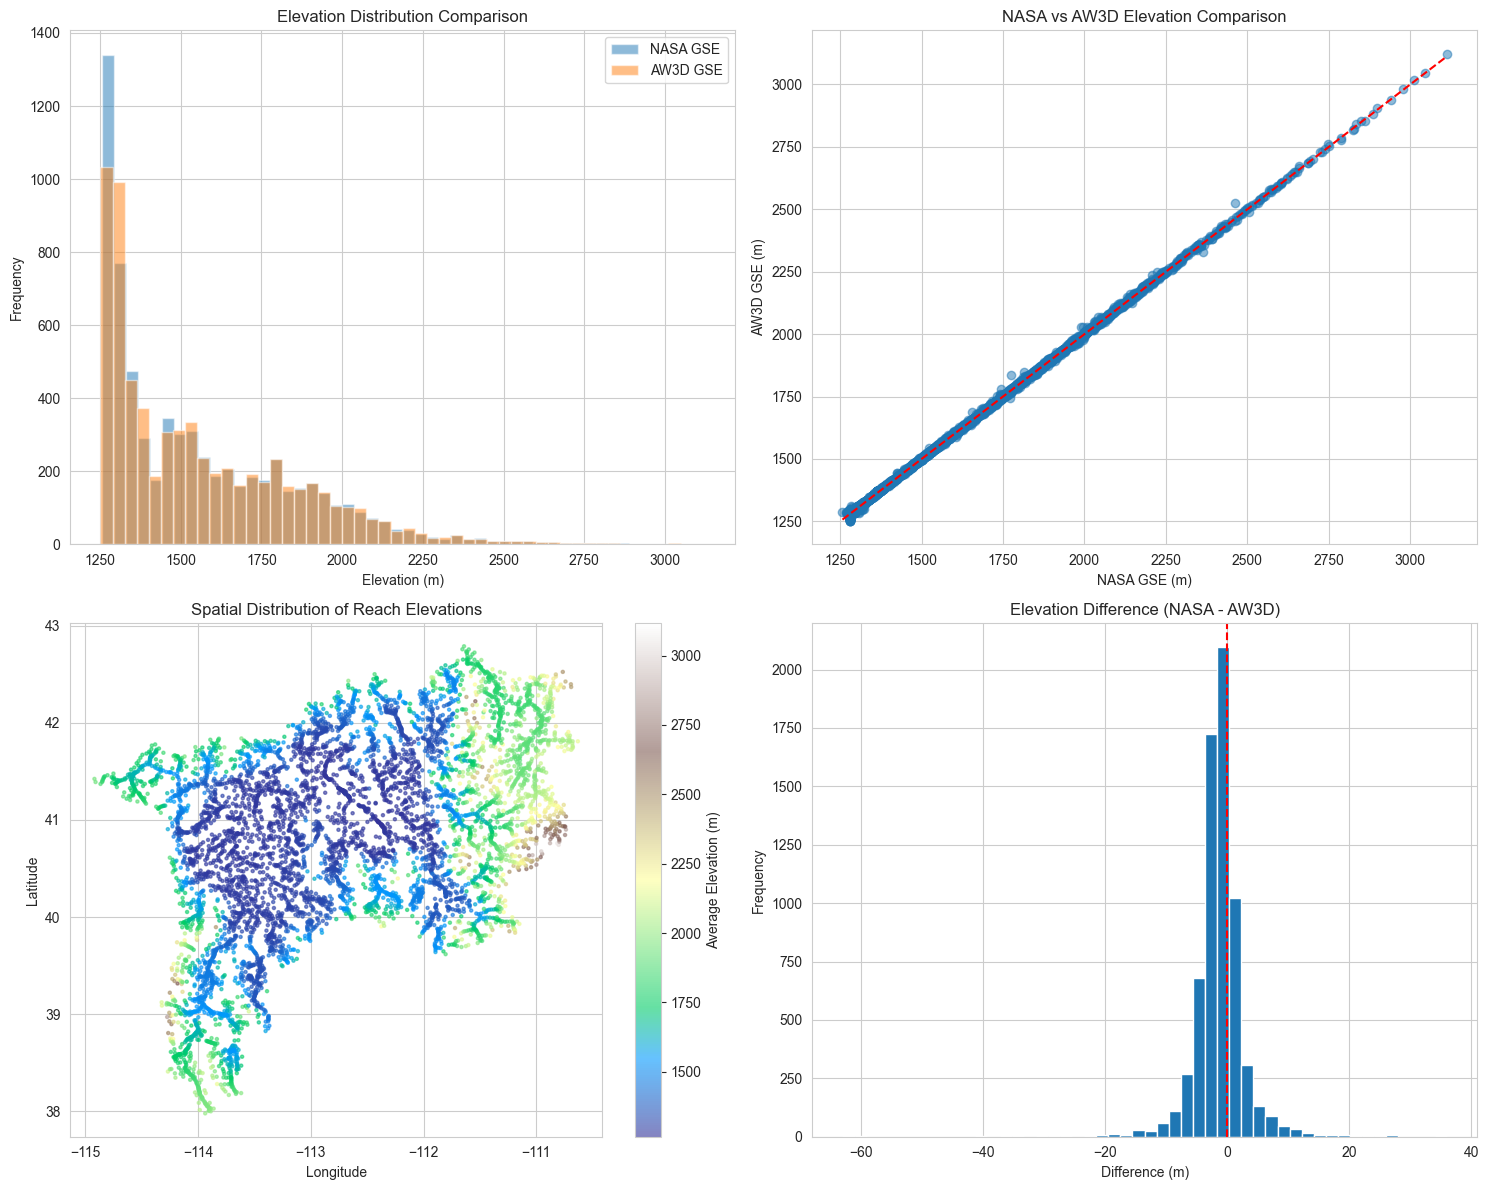

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Elevation distribution comparison
axes[0, 0].hist(reach_elev['NASA_GSE'], bins=50, alpha=0.5, label='NASA GSE')
axes[0, 0].hist(reach_elev['AW3D_GSE'], bins=50, alpha=0.5, label='AW3D GSE')
axes[0, 0].set_title('Elevation Distribution Comparison')
axes[0, 0].set_xlabel('Elevation (m)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Plot 2: Scatter of NASA vs AW3D elevations
axes[0, 1].scatter(reach_elev['NASA_GSE'], reach_elev['AW3D_GSE'], alpha=0.5)
axes[0, 1].plot([reach_elev['NASA_GSE'].min(), reach_elev['NASA_GSE'].max()],
                [reach_elev['NASA_GSE'].min(), reach_elev['NASA_GSE'].max()], 'r--')
axes[0, 1].set_title('NASA vs AW3D Elevation Comparison')
axes[0, 1].set_xlabel('NASA GSE (m)')
axes[0, 1].set_ylabel('AW3D GSE (m)')

# Plot 3: Spatial distribution colored by average elevation
scatter = axes[1, 0].scatter(reach_elev['Longitude'], reach_elev['Latitude'],
                             c=reach_elev['Avg_GSE'], cmap='terrain',
                             s=5, alpha=0.6)
axes[1, 0].set_title('Spatial Distribution of Reach Elevations')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[1, 0], label='Average Elevation (m)')

# Plot 4: Elevation difference histogram
diff = reach_elev['NASA_GSE'] - reach_elev['AW3D_GSE']
axes[1, 1].hist(diff, bins=50)
axes[1, 1].set_title('Elevation Difference (NASA - AW3D)')
axes[1, 1].set_xlabel('Difference (m)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Nearest distance to the reach

## Extracting reach centroids

In [30]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import Point
from tqdm import tqdm

def extract_reach_centroids(stream_gdf):
    """
    Extract centroids from stream reaches in the required format

    Parameters:
    -----------
    stream_gdf : GeoDataFrame
        Stream network data with geometries

    Returns:
    --------
    DataFrame with reach centroids in decimal degrees
    """
    # Ensure the geometry is in geographic coordinates (WGS84)
    if stream_gdf.crs != "EPSG:4326":
        stream_gdf = stream_gdf.to_crs("EPSG:4326")

    # Extract centroids
    centroids = []
    print("Extracting reach centroids...")
    for reach in tqdm(stream_gdf.itertuples(), total=len(stream_gdf)):
        centroid = reach.geometry.centroid
        centroids.append({
            'Reach_ID': reach.LINKNO,
            'Latitude': centroid.y,
            'Longitude': centroid.x
        })

    # Convert to DataFrame
    centroids_df = pd.DataFrame(centroids)

    # Save centroids to CSV
    output_file = '../data/processed/reach_centroids.csv'
    centroids_df.to_csv(output_file, index=False)
    print(f"\nCentroids saved to: {output_file}")

    return centroids_df

In [31]:
centroids_df = extract_reach_centroids(gslb_stream)
centroids_df

Extracting reach centroids...


100%|██████████| 6717/6717 [00:00<00:00, 129519.17it/s]


Centroids saved to: ../data/processed/reach_centroids.csv


Reach_ID   Latitude   Longitude
0     710706491.0  40.652682 -113.720750
1     710831483.0  40.648360 -113.909942
2     710910842.0  40.650277 -113.802024
3     710833466.0  40.686236 -113.870476
4     710912826.0  40.660520 -113.790474
...           ...        ...         ...
6712  710609238.0  41.362341 -111.141662
6713  710781840.0  41.466748 -111.149335
6714  710510031.0  41.481595 -111.144827
6715  710809614.0  41.532070 -111.132101
6716  710783824.0  41.479203 -111.139589

[6717 rows x 3 columns]

## find the nearest reach for the wells

In [51]:
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm

def process_wells_and_reaches(wells_gdf, stream_gdf, gages_df, centroids_elev_df):
    """
    Process wells and stream reaches with correct UTM distance calculations
    """
    # Convert to UTM projection (EPSG:32612 for Utah area)
    print("Converting coordinate systems to UTM...")
    wells_utm = wells_gdf.to_crs("EPSG:32612")
    stream_utm = stream_gdf.to_crs("EPSG:32612")

    print(f"Coordinate systems after conversion:")
    print(f"Wells CRS: {wells_utm.crs}")
    print(f"Streams CRS: {stream_utm.crs}")

    results = []
    total_wells = len(wells_utm)

    print("\nProcessing wells...")
    for well in tqdm(wells_utm.itertuples(), total=total_wells):
        # Calculate distances in meters
        distances = stream_utm.geometry.distance(well.geometry)
        nearest_reach_idx = distances.idxmin()
        nearest_reach = stream_utm.iloc[nearest_reach_idx]
        min_distance = distances.min()

        # Get reach elevation
        reach_elev_data = centroids_elev_df[
            centroids_elev_df['Reach_ID'] == nearest_reach['LINKNO']
        ]

        reach_elevation = reach_elev_data.iloc[0]['Avg_GSE'] if not reach_elev_data.empty else None

        # Find downstream gage
        downstream_gage = find_downstream_gage(
            nearest_reach['LINKNO'],
            stream_gdf,
            gages_df
        )

        # Store results
        results.append({
            'Well_ID': well.Well_ID,
            'Reach_ID': nearest_reach['LINKNO'],
            'Reach_Elevation': reach_elevation,
            'Distance_to_Reach': min_distance,  # Now correctly in meters
            'Downstream_Gage': downstream_gage
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total wells processed: {len(results_df)}")
    print(f"Wells with downstream gages: {results_df['Downstream_Gage'].notna().sum()}")
    print(f"Wells with reach elevations: {results_df['Reach_Elevation'].notna().sum()}")
    print("\nDistance statistics (meters):")
    print(f"  Minimum: {results_df['Distance_to_Reach'].min():.2f} m")
    print(f"  Maximum: {results_df['Distance_to_Reach'].max():.2f} m")
    print(f"  Average: {results_df['Distance_to_Reach'].mean():.2f} m")
    print(f"  Median: {results_df['Distance_to_Reach'].median():.2f} m")

    # Calculate distance distribution
    percentiles = [10, 25, 50, 75, 90]
    dist_percentiles = np.percentile(results_df['Distance_to_Reach'], percentiles)
    print("\nDistance percentiles (meters):")
    for p, v in zip(percentiles, dist_percentiles):
        print(f"  {p}th percentile: {v:.2f} m")

    # Save results
    output_file = '../data/features/well_reach_relationships_final.csv'
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")

    return results_df

def find_downstream_gage(reach_id, stream_gdf, gages_df):
    """
    Find downstream gage using network topology
    """
    current_reach = reach_id
    visited_reaches = set()
    path_length = 0

    while current_reach and path_length < 100:  # Limit path length to 100 reaches
        if current_reach in visited_reaches:
            break
        visited_reaches.add(current_reach)

        # Check for gage on current reach
        gage_on_reach = gages_df[gages_df['COMID_v2'] == current_reach]
        if not gage_on_reach.empty:
            return gage_on_reach.iloc[0]['samplingFeatureCode']  # Use samplingFeatureCode instead of 'id'

        # Move downstream
        reach_row = stream_gdf[stream_gdf['LINKNO'] == current_reach]
        if reach_row.empty:
            break

        downstream_id = reach_row.iloc[0]['DSLINKNO']
        if downstream_id == 0 or pd.isna(downstream_id):
            break

        current_reach = downstream_id
        path_length += 1

    return None

In [36]:
# Read the shapefile
display(well_shp.head())

Well_ID          Well_Name    lat_dec    long_dec     GSE  AquiferID  \
0  3.810331e+14  (C-30-18)25aad- 1  38.175796 -113.802750  7098.0          1   
1  3.810371e+14  (C-30-17)30bab- 1  38.176306 -113.795500  7193.0          1   
2  3.811521e+14  (C-30-17)15cab- 1  38.197833 -113.741167  6550.0          1   
3  3.812361e+14  (C-30-18)12cdb- 1  38.210028 -113.815500  7190.0          1   
4  3.821131e+14  (C-28-17)22dda- 1  38.353571 -113.732473  5775.0          1   

  Aquifer_Na State                     geometry  
0  GSL Basin    UT   POINT (-113.80275 38.1758)  
1  GSL Basin    UT   POINT (-113.7955 38.17631)  
2  GSL Basin    UT  POINT (-113.74117 38.19783)  
3  GSL Basin    UT   POINT (-113.8155 38.21003)  
4  GSL Basin    UT  POINT (-113.73247 38.35357)

In [48]:
gsl_nwm = pd.read_csv('../data/raw/streamflow/gsl_nwm.csv')
gsl_nwm.head()

Data_Source         Folder  samplingFeatureCode  \
0         USA  North_America             10011200   
1         USA  North_America             10011500   
2         USA  North_America             10015700   
3         USA  North_America             10015900   
4         USA  North_America             10016900   

                                                name                 River  \
0  WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...  WEST FORK BEAR RIVER   
1            BEAR RIVER NEAR UTAH-WYOMING STATE LINE            BEAR RIVER   
2  SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...         SULPHUR CREEK   
3       SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.         SULPHUR CREEK   
4                        BEAR RIVER AT EVANSTON - WY            BEAR RIVER   

    latitude   longitude  elevation_m    state county  ... elevationDatum  \
0  40.841614 -110.927119         2797     Utah   USGS  ...       NASA_GSE   
1  40.965225 -110.853508         2432     Utah   USGS  ...       NASA_GSE   
2  41.129114 -110.806563         2205  Wyoming   USGS  ...       NASA_GSE   
3  41.156058 -110.835176         2173  Wyoming   USGS  ...       NASA_GSE   
4  41.270224 -110.963793         2057  Wyoming   USGS  ...       NASA_GSE   

                                         description     Q     WL  \
0  Stream: WEST FORK BEAR RIVER. GEGOGloWS v1 COM...  True  False   
1  Stream: BEAR RIVER. GEGOGloWS v1 COMID: 130641...  True  False   
2  Stream: SULPHUR CREEK. GEGOGloWS v1 COMID: 130...  True  False   
3  Stream: SULPHUR CREEK. GEGOGloWS v1 COMID: 130...  True  False   
4  Stream: BEAR RIVER. GEGOGloWS v1 COMID: 130634...  True  False   

                                      dataDisclaimer   COMID_v2  isVisible  \
0  The data provided is intended for research and...  710587441       True   
1  The data provided is intended for research and...  710746154       True   
2  The data provided is intended for research and...  710865186       True   
3  The data provided is intended for research and...  710748128       True   
4  The data provided is intended for research and...  710859226       True   

   GEOGloWS_v1_region GEOGloWS_v2_vpu  matching_column  
0       north_america             703     usa_10011200  
1       north_america             703     usa_10011500  
2       north_america             703     usa_10015700  
3       north_america             703     usa_10015900  
4       north_america             703     usa_10016900  

[5 rows x 24 columns]

In [52]:
centroids_elev_df = pd.read_csv('../data/raw/streamflow/reach_centroids_with_Elev.csv')

# Load the complete gage data with COMID_v2 mapping
gages_with_comid = pd.read_csv('../data/raw/streamflow/gsl_nwm.csv')

# Run analysis
results = process_wells_and_reaches(
    well_shp,
    gslb_stream,
    gages_with_comid,  # Use the complete dataset with COMID_v2
    centroids_elev_df
)

Converting coordinate systems to UTM...
Coordinate systems after conversion:
Wells CRS: EPSG:32612
Streams CRS: EPSG:32612

Processing wells...


100%|██████████| 8752/8752 [03:13<00:00, 45.20it/s]


Summary Statistics:
Total wells processed: 8752
Wells with downstream gages: 4861
Wells with reach elevations: 8752

Distance statistics (meters):
  Minimum: 0.00 m
  Maximum: 5845.15 m
  Average: 727.63 m
  Median: 567.54 m

Distance percentiles (meters):
  10th percentile: 83.51 m
  25th percentile: 238.05 m
  50th percentile: 567.54 m
  75th percentile: 1046.09 m
  90th percentile: 1574.03 m

Results saved to: ../data/features/well_reach_relationships_final.csv


In [11]:
# Wells Map for GSLB with Geographic Context
import matplotlib.pyplot as plt
import numpy as np

# Create map with geographic context
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Plot geographic features
gsl_basin.plot(ax=ax, color='#F8F9FA', alpha=0.8, edgecolor='#2C3E50', linewidth=2.5)
gsl_catchment.plot(ax=ax, color='none', edgecolor='#BDC3C7', linewidth=0.3, alpha=0.6)
gslb_stream.plot(ax=ax, color='#85C1E9', linewidth=0.6, alpha=0.7)
lake.plot(ax=ax, color='#3498DB', alpha=0.8)

# Plot wells with larger points
well_shp.plot(ax=ax, color='#E74C3C', markersize=4, alpha=0.9)

# Set map styling
ax.set_title('Great Salt Lake Basin - Groundwater Wells', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')

# Simplified well statistics
if 'wte_data' in locals():
    total_measurements = len(wte_data)
    date_range = f"{wte_data['Date'].min().strftime('%Y')}-{wte_data['Date'].max().strftime('%Y')}"
else:
    total_measurements = "N/A"
    date_range = "N/A"

# Concise information panel - removed DATA line
info_text = f"""WELLS: {len(well_shp):,}
MEASUREMENTS: {total_measurements:,}
PERIOD: {date_range}"""

# Add compact information box
bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.95, 
                 edgecolor='#2C3E50', linewidth=2)
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=bbox_props, family='monospace')

# Complete legend with all features - no numbers
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', 
               markersize=8, label='Wells', linestyle='None'),
    plt.Line2D([0], [0], color='#85C1E9', linewidth=3, label='Streams'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#3498DB', 
               markersize=8, label='Lakes', linestyle='None'),
    plt.Line2D([0], [0], color='#BDC3C7', linewidth=2, label='Catchments'),
    plt.Line2D([0], [0], color='#2C3E50', linewidth=3, label='Basin Boundary')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=12, 
          frameon=True, fancybox=True, shadow=True)

# Clean appearance
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_facecolor('#F7F9FC')

plt.tight_layout()
plt.show()

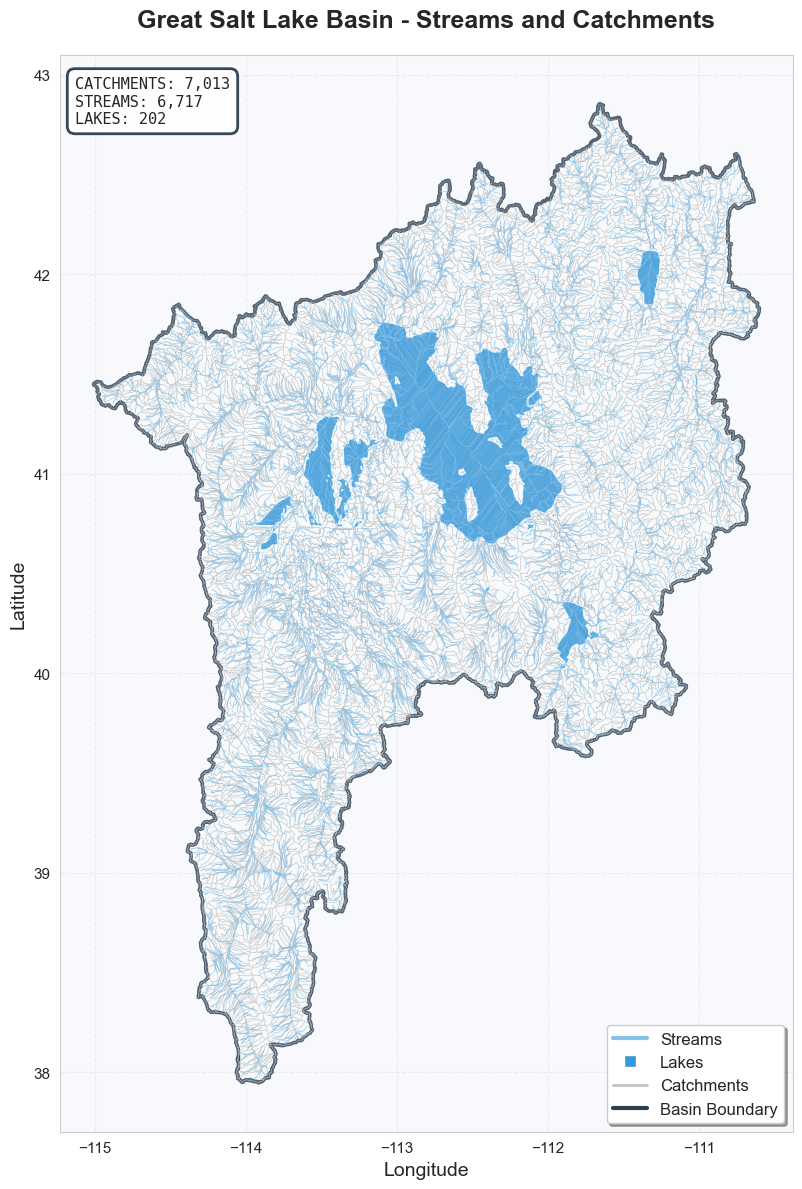

In [14]:
# Map of Streams and Catchments for GSLB
import matplotlib.pyplot as plt
import numpy as np

# Create map with geographic context
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Plot geographic features
gsl_basin.plot(ax=ax, color='#F8F9FA', alpha=0.8, edgecolor='#2C3E50', linewidth=2.5)
gsl_catchment.plot(ax=ax, color='none', edgecolor='#BDC3C7', linewidth=0.3, alpha=0.6)
gslb_stream.plot(ax=ax, color='#85C1E9', linewidth=0.6, alpha=0.7)
lake.plot(ax=ax, color='#3498DB', alpha=0.8)

# Set map styling
ax.set_title('Great Salt Lake Basin - Streams and Catchments', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')

# Stream and catchment statistics
info_text = f"""CATCHMENTS: {len(gsl_catchment):,}
STREAMS: {len(gslb_stream):,}
LAKES: {len(lake)}"""

# Add compact information box
bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.95, 
                 edgecolor='#2C3E50', linewidth=2)
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=bbox_props, family='monospace')

# Complete legend with all features - no numbers
legend_elements = [
    plt.Line2D([0], [0], color='#85C1E9', linewidth=3, label='Streams'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#3498DB', 
               markersize=8, label='Lakes', linestyle='None'),
    plt.Line2D([0], [0], color='#BDC3C7', linewidth=2, label='Catchments'),
    plt.Line2D([0], [0], color='#2C3E50', linewidth=3, label='Basin Boundary')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=12, 
          frameon=True, fancybox=True, shadow=True)

# Clean appearance
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_facecolor('#F7F9FC')

plt.tight_layout()
plt.show()

In [13]:
# Wells Map for GSLB with Geographic Context
import matplotlib.pyplot as plt
import numpy as np

# Create map with geographic context
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Plot geographic features
gsl_basin.plot(ax=ax, color='#F8F9FA', alpha=0.8, edgecolor='#2C3E50', linewidth=2.5)
gsl_catchment.plot(ax=ax, color='none', edgecolor='#BDC3C7', linewidth=0.3, alpha=0.6)
gslb_stream.plot(ax=ax, color='#85C1E9', linewidth=0.6, alpha=0.7)
lake.plot(ax=ax, color='#3498DB', alpha=0.8)

# Plot wells with larger points
well_shp.plot(ax=ax, color='#E74C3C', markersize=4, alpha=0.9)

# Set map styling
ax.set_title('Great Salt Lake Basin - Groundwater Wells',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')

# Simplified well statistics
if 'wte_data' in locals():
    total_measurements = len(wte_data)
    date_range = f"{wte_data['Date'].min().strftime('%Y')}-{wte_data['Date'].max().strftime('%Y')}"
else:
    total_measurements = "N/A"
    date_range = "N/A"

# Concise information panel - removed DATA line
info_text = f"""WELLS: {len(well_shp):,}
MEASUREMENTS: {total_measurements:,}
PERIOD: {date_range}"""

# Add compact information box
bbox_props = dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.95,
                 edgecolor='#2C3E50', linewidth=2)
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=bbox_props, family='monospace')

# Complete legend with all features - no numbers
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C',
               markersize=8, label='Wells', linestyle='None'),
    plt.Line2D([0], [0], color='#85C1E9', linewidth=3, label='Streams'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#3498DB',
               markersize=8, label='Lakes', linestyle='None'),
    plt.Line2D([0], [0], color='#BDC3C7', linewidth=2, label='Catchments'),
    plt.Line2D([0], [0], color='#2C3E50', linewidth=3, label='Basin Boundary')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=12,
          frameon=True, fancybox=True, shadow=True)

# Clean appearance
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_facecolor('#F7F9FC')

plt.tight_layout()
plt.show()